In [1]:
import pandas as pd
import time
import numpy as np
from ClusteringPredictiveModel import ClusteringPredictiveModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from  matplotlib import pyplot
from sklearn.ensemble import RandomForestClassifier
from LastStateEncoder import LastStateEncoder
from IPython.display import display, clear_output
import difflib as diff
import matplotlib.pyplot as plt
import pickle

In [2]:
data=pd.read_csv('BPIC 2017 just complete cases.csv',sep=';')

In [3]:
#with open('SimilarityMatrix.pkl', 'wb') as fp : # wb for "write bytes"
#    pickle.dump(similarities, fp)
with open ('SimilarityMatrix.pkl', 'rb') as fp:
     similarities = pickle.load(fp)

In [4]:
#with open('train_cases.pkl', 'wb') as fp : # wb for "write bytes"
#    pickle.dump(train_cases, fp)
with open ('train_cases.pkl', 'rb') as fp:
     train_cases = pickle.load(fp)

In [23]:
#with open('test_cases.pkl', 'wb') as fp : # wb for "write bytes"
#    pickle.dump(test_cases, fp)
with open ('test_cases.pkl', 'rb') as fp:
     test_cases = pickle.load(fp)

In [6]:
n_clusters = 6

In [7]:
#global case_id_col,event_col,timestamp_col,label_col,pos_label,numeric_cols,meta_event_data,other_col,variant_col

case_id_col = "Case ID"
event_col = "Activity"
timestamp_col = ["Complete Timestamp"]
label_col = 'lbl'
pos_label = 'A_Pending'
cat_cols = ['(case) LoanGoal','(case) ApplicationType'] 
numeric_cols = [ '(case) RequestedAmount',label_col]  
meta_event_data=['Start Timestamp','EventOrigin','OfferID','Unnamed: 0','Transition','milli_seconds',
          'EventID','lifecycle:transition','days','D_seconds',
          'Accepted', 'Selected' ,
          'FirstWithdrawalAmount', 'MonthlyCost', 'NumberOfTerms','outcome',
          'Resource','Variant', 'Action', 'CreditScore','OfferedAmount'
          ]
other_col= '(case) RequestedAmount'
variant_col='Variant index'

In [8]:
data.drop(meta_event_data,axis=1,inplace=True)
data.drop(variant_col,axis=1,inplace=True)

In [9]:
from sklearn.preprocessing import LabelEncoder
lb_make = LabelEncoder()
data['Activity'] = lb_make.fit_transform(data['Activity'])

data.head() #Results in appending a new column to df

Case ID  Activity       Complete Timestamp  \
0  Application_652823628         4  2016/01/01 10:51:15.304   
1  Application_652823628         8  2016/01/01 10:51:15.352   
2  Application_652823628         3  2016/01/01 10:52:36.413   
3  Application_652823628        21  2016/01/02 11:45:22.429   
4  Application_652823628         0  2016/01/02 12:23:04.299   

  (case) ApplicationType         (case) LoanGoal  (case) RequestedAmount  \
0             New credit  Existing loan takeover                 20000.0   
1             New credit  Existing loan takeover                 20000.0   
2             New credit  Existing loan takeover                 20000.0   
3             New credit  Existing loan takeover                 20000.0   
4             New credit  Existing loan takeover                 20000.0   

         lbl  
0  A_Pending  
1  A_Pending  
2  A_Pending  
3  A_Pending  
4  A_Pending

In [10]:
train=data[data['Case ID'].isin(train_cases)]
test=data[data['Case ID'].isin(test_cases)]

In [11]:
def trace(x):
    l=''
    for ac in x['Activity']:
        l+=chr(int(ac)+ascii_offset)
    return l


ascii_offset=161

# aggregate activities by case
grouped = train.groupby(['Case ID'], sort=False)

# extract  encoded trace from actvities
Activities_train = grouped.apply(lambda x: trace(x) )

In [12]:
train=data[data['Case ID'].isin(Activities_train.index)]

In [13]:
def getGramsNumber(string, q):
    return (len(string) + (q - 1) * 2 + 1) - q

In [14]:
def getUnNormalisedSimilarity(s1, s2, q):
    difference = 0
    array3temp=[]
    array3temp.extend(s1)
    array3temp.extend(s2)
    #array3=array3temp
    array3 = np.unique(array3temp)
    
    for i  in range(len(array3)):
        token = array3[i]
        matchingQGrams1 = s1.count(token)
        matchingQGrams2 = s2.count(token)
        if matchingQGrams1 > matchingQGrams2 :
            difference += matchingQGrams1 - matchingQGrams2
        else:
            difference += matchingQGrams2 - matchingQGrams1
    return difference

In [15]:
# function of q_grams_similarity

def q_grams_similarity(string1, string2, q):
    array1_steps = getGramsNumber(string1, q)
    array2_steps = getGramsNumber(string2, q)
    maxQGramsMatching = array1_steps + array2_steps
    if (maxQGramsMatching == 0):
        return 0.00;
    else :
        return (maxQGramsMatching - getUnNormalisedSimilarity(string1, string2, q)) / maxQGramsMatching
            
    

In [16]:
#This function returns the symmetric matrix associated to a triangular matrix
#It returns a matrix
def symmetrize(a):
    return a + a.T - np.diag(a.diagonal())

In [17]:
numberOfUsers=Activities_train.shape[0]

In [18]:
''''
q=2

start = time.time()
similarities=np.zeros([numberOfUsers,numberOfUsers])
for i in range(numberOfUsers) :
    clear_output(wait=True)
    print("Calculating similarities for : ",i, end='\r')
    
    for j in range(numberOfUsers) :
        if j>i: #Only generate the lower triangular values
            break
        elif i==j:
            similarities[i][j]=1
        else :
            similarities[i][j]= (diff.SequenceMatcher(None, Activities_train[i],Activities_train[j]).ratio()
                                 +
                                 q_grams_similarity(Activities_train[i],Activities_train[j],q))/2

end = time.time()
print("Elapsed time : ",end - start)

SyntaxError: EOF while scanning triple-quoted string literal (<ipython-input-18-dc037d47249a>, line 21)

In [20]:
#Symmetrize the matrix as we only computed the lower triangular values
#similarities=symmetrize(similarities)

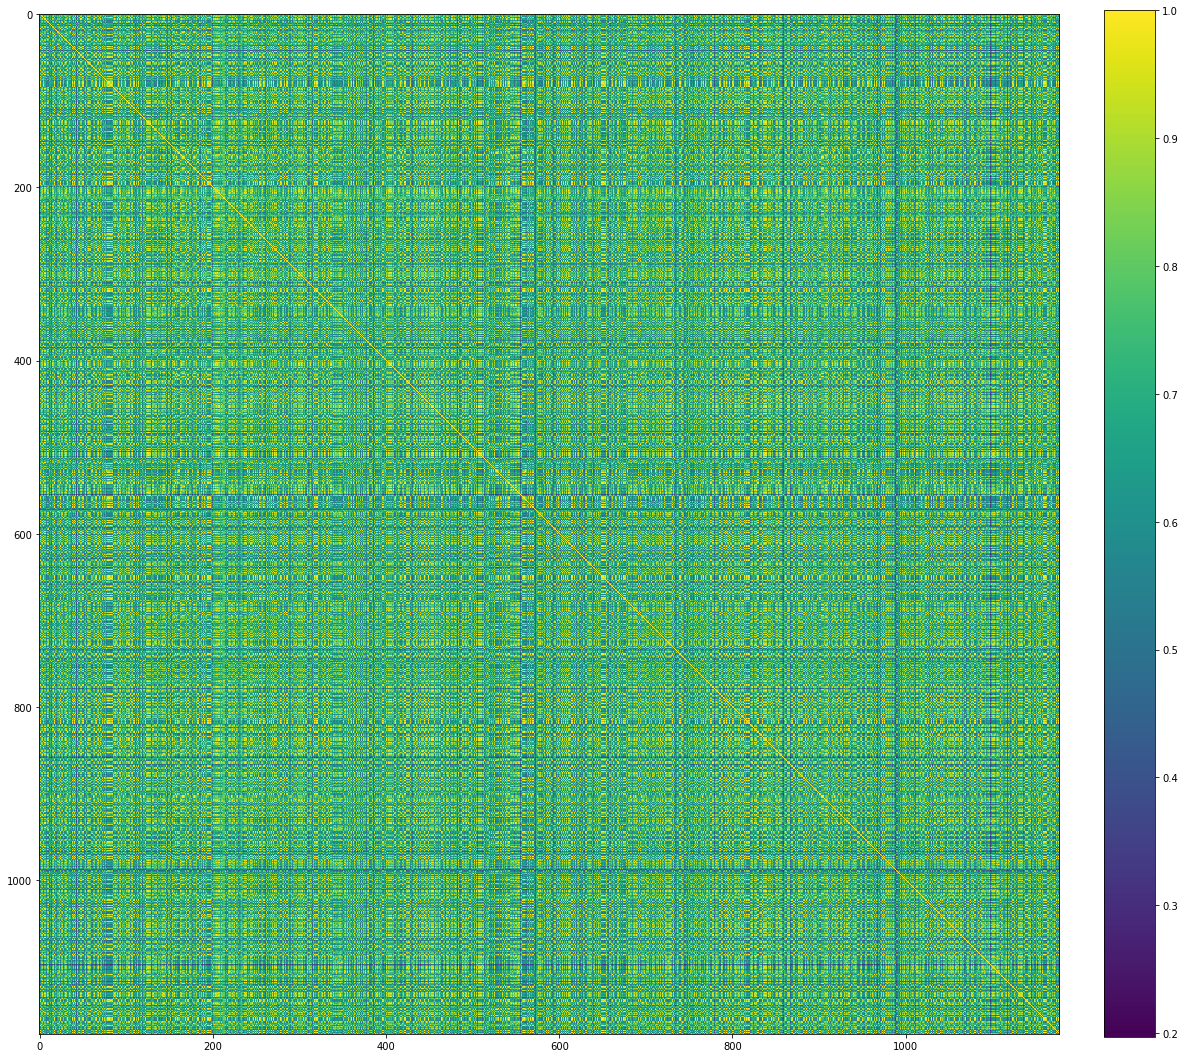

In [23]:
"""""
plt.figure(1, figsize=(20,20))
heatmap=plt.imshow(similarities, cmap='viridis', interpolation='nearest')
plt.colorbar(heatmap,fraction=0.046, pad=0.04)
plt.show()

In [18]:
# fit model (cluster traces and build classifier for each cluster)
model = ClusteringPredictiveModel(similarities,Activities_train,case_id_col, event_col, label_col, timestamp_col, cat_cols, numeric_cols, n_clusters=n_clusters, n_estimators=100, random_state=22, fillna=True)
model.fit(train)

[2 2 3 ..., 4 2 1]
['Application_857715587', 'Application_495055221', 'Application_1358464831', 'Application_1812699529', 'Application_201324137', 'Application_292974495', 'Application_1787170984', 'Application_1343799374', 'Application_1600450105', 'Application_992706633', 'Application_1889831782', 'Application_545562925', 'Application_1313000546', 'Application_2135934356', 'Application_813921157', 'Application_1195543683', 'Application_1310784703', 'Application_712697877', 'Application_2110141037', 'Application_998310056', 'Application_11615304', 'Application_575892243', 'Application_1863055447', 'Application_229066208', 'Application_1737530400', 'Application_1987325366', 'Application_2019785587', 'Application_949933933', 'Application_1940358661', 'Application_721103002', 'Application_1403562604', 'Application_1683981400', 'Application_853708322', 'Application_1504625878', 'Application_942363254', 'Application_882783467', 'Application_1869629043', 'Application_1205576016', 'Applicati

['Application_323012882', 'Application_1138826038', 'Application_493812399', 'Application_1764180224', 'Application_344339957', 'Application_870009989', 'Application_1549089757', 'Application_1508092841', 'Application_96006350', 'Application_792000013', 'Application_714305626', 'Application_1276655609', 'Application_1647772582', 'Application_428362155', 'Application_551059309', 'Application_480362069', 'Application_1674089102', 'Application_413083060', 'Application_1794795437', 'Application_1756165830', 'Application_81202491', 'Application_752441949', 'Application_1816982255', 'Application_878258869', 'Application_1424383499', 'Application_658773748', 'Application_1532124749', 'Application_336221196', 'Application_1749959518', 'Application_1747116184', 'Application_1105262339', 'Application_2127289160', 'Application_1465545257', 'Application_256653272', 'Application_378405435', 'Application_29347740', 'Application_369263900', 'Application_1924569456', 'Application_412179632', 'Applicat

                                              Case ID  (case) RequestedAmount  \
Case ID                                                                         
Application_1005465952 301928  Application_1005465952                 42000.0   
Application_1008980114 226670  Application_1008980114                 49000.0   
Application_1009117608 91893   Application_1009117608                 12900.0   
Application_101073762  420615   Application_101073762                 14250.0   
Application_1014808270 223390  Application_1014808270                 17000.0   
Application_101973919  461581   Application_101973919                 42000.0   
Application_1019756607 493054  Application_1019756607                 25000.0   
Application_1035739361 522946  Application_1035739361                 12000.0   
Application_1039990121 496902  Application_1039990121                  5000.0   
Application_1044965535 235297  Application_1044965535                 12500.0   
Application_1046834008 44134

                                              Case ID  (case) RequestedAmount  \
Case ID                                                                         
Application_1003146166 540826  Application_1003146166                 30000.0   
Application_1011933027 310611  Application_1011933027                  5000.0   
Application_1017122987 85130   Application_1017122987                  5000.0   
Application_1036967529 134104  Application_1036967529                  8000.0   
Application_1054793147 338183  Application_1054793147                 10000.0   
Application_1056628969 538029  Application_1056628969                  6000.0   
Application_1080844867 557169  Application_1080844867                 10000.0   
Application_108387178  223488   Application_108387178                  5000.0   
Application_1102933096 485090  Application_1102933096                  5000.0   
Application_1109722425 447836  Application_1109722425                 10000.0   
Application_1111090727 13636

                                              Case ID  (case) RequestedAmount  \
Case ID                                                                         
Application_1018615109 370     Application_1018615109                17000.00   
Application_1019277788 224203  Application_1019277788                15000.00   
Application_1028335742 541313  Application_1028335742                10000.00   
Application_1031512096 463987  Application_1031512096                 7000.00   
Application_1048834285 466298  Application_1048834285                    0.00   
Application_1051554620 189010  Application_1051554620                16000.00   
Application_107058559  529829   Application_107058559                13000.00   
Application_1081561286 252038  Application_1081561286                24000.00   
Application_1081677393 304775  Application_1081677393                20000.00   
Application_1081779435 522706  Application_1081779435                15000.00   
Application_1089717788 18899

['Application_1193723578', 'Application_125495187', 'Application_1470184564', 'Application_1771304108', 'Application_2081147987', 'Application_1569845993', 'Application_163121479', 'Application_834711528', 'Application_2031072542', 'Application_1341217021', 'Application_1693405530', 'Application_919407038', 'Application_1100457126', 'Application_696734932', 'Application_2145932809', 'Application_1814325221', 'Application_564276126', 'Application_623888087', 'Application_450220910', 'Application_938221508', 'Application_907020089', 'Application_785468545', 'Application_916132326', 'Application_1484781251', 'Application_1995862436', 'Application_1820191297', 'Application_1307844760', 'Application_1214550142', 'Application_438652225', 'Application_2053360998', 'Application_861174392', 'Application_741039245', 'Application_577491572', 'Application_81911405', 'Application_707700019', 'Application_1158377896', 'Application_555108256', 'Application_1841328925', 'Application_831994177', 'Appli

                                              Case ID  (case) RequestedAmount  \
Case ID                                                                         
Application_1004618053 291716  Application_1004618053                     0.0   
Application_1004943461 19756   Application_1004943461                  9000.0   
Application_1005586643 194465  Application_1005586643                 10000.0   
Application_1005851562 144861  Application_1005851562                  5000.0   
Application_1008477029 46383   Application_1008477029                 20000.0   
Application_1020819842 443784  Application_1020819842                 66600.0   
Application_102597720  447483   Application_102597720                 12000.0   
Application_1044610848 2315    Application_1044610848                 50000.0   
Application_1050447885 321518  Application_1050447885                  5000.0   
Application_1054727336 261313  Application_1054727336                 10000.0   
Application_1059131551 17134

In [70]:
def trace(x):
    l=''
    l=np.array(x['Activity'])
    return l


ascii_offset=161

# aggregate activities by case
grouped = test.groupby(['Case ID'], sort=False)

# extract  encoded trace from actvities
Activities_test = grouped.apply(lambda x: trace(x) )
#test=data[data['Case ID'].isin(Activities_test.index)]

In [71]:
str(list(test['Activity'][0:10].values))

'[4, 8, 3, 21, 0, 12, 13, 16, 19, 2]'

In [77]:
np.array(Activities_test)

array([ array([ 4,  8,  3, 21,  0, 12, 13, 16, 19,  2, 12, 13, 16, 25,  9, 15, 10,
        7, 11]),
       array([ 4,  8,  3, 21,  0, 12, 13,  5, 14]),
       array([ 4,  8,  3, 21,  0, 12, 13, 12, 13, 16, 16, 19,  2, 12, 13, 16,  1,
       11, 11, 11]),
       array([ 4,  8,  3, 21,  0, 12, 13, 16, 19,  2, 25,  9, 15,  5, 14]),
       array([ 4, 21,  3,  0, 12, 13, 16, 19,  2, 25,  9, 15, 20,  6, 10,  7]),
       array([ 4,  8,  3, 21,  0, 12, 13, 11, 12, 13, 16, 19,  2, 25,  9, 15,  5,
       14]),
       array([ 4,  8,  3, 21,  0, 12, 13, 16, 19,  2,  1, 11]),
       array([ 4, 21,  3,  0, 12, 13, 16, 19,  2, 12, 13, 16,  1, 11, 11]),
       array([ 4,  8,  3, 21,  0, 12, 13, 16, 19,  2, 12, 13, 16, 25,  9, 15, 20,
        6, 25,  9, 20,  6, 25,  9, 20,  6, 25,  9, 20,  6, 25,  9, 10,  7,
       11]),
       array([ 4, 21,  3,  0, 12, 13, 16, 19,  2, 25,  9, 15, 20,  6, 20, 25,  9,
       10,  7]),
       array([ 4,  8,  3, 21,  0, 12, 13, 16, 19,  2, 25,  9, 15, 20,  6, 10,  7]),
 

In [78]:
# predict for test set (assign each trace to the closest cluster and predict outcome using the corresponding classifier)
preds = model.predict_proba(test,np.array(Activities_test) )

ValueError: setting an array element with a sequence.

In [21]:
model.clustering.affinity_matrix_=similarities

In [27]:
# trim first n activity
#######################

n=12
n_events=test_KMeans.groupby(['Case ID']).apply(lambda x: x.head(n)).droplevel(1)
#n_events=pd.DataFrame(columns=test_KMeans.columns)
#for i in test_cases_KMeans:
    #cc=test_KMeans[test_KMeans['Case ID']==i]
    #n_events=n_events.append(test_KMeans[test_KMeans['Case ID']==i][0:n])
#n_events=test_KMeans[test_KMeans.index.isin(n_events.index) ]

In [120]:
# events from '''''''  to '''''''
#if not: from_event=A_Create Application

from_event= 'A_Submitted'

to_event  = 'A_Accepted'

from_to=pd.DataFrame(columns=test_KMeans.columns)
#idx=dd[dd['Activity'].values==from_event].index
#idx2=dd[dd['Activity'].values==to_event].index  
#cd=test_KMeans[test_KMeans.index.isin (range(idx[0],idx2[0]+1))]

for i in test_cases_KMeans:
    dd=test_KMeans[test_KMeans['Case ID']==i]
    idx=dd[dd['Activity'].values==from_event].index
    if not idx.any():
        idx=dd[dd['Activity'].values=='A_Create Application'].index
    idx2=dd[dd['Activity'].values==to_event].index 
    from_to=from_to.append(test_KMeans[test_KMeans.index.isin (range(idx[0],idx2[0]+1))])

In [121]:
# events from '''''''  to '''''''
#if not: from_event=A_Create Application

from_event= 'A_Accepted'

to_event  = 'O_Sent (mail and online)'

#from_to=pd.DataFrame(columns=test_KMeans.columns)
#idx=dd[dd['Activity'].values==from_event].index
#idx2=dd[dd['Activity'].values==to_event].index  
#cd=test_KMeans[test_KMeans.index.isin (range(idx[0],idx2[0]+1))]

for i in test_cases_KMeans:
    dd=test_KMeans[test_KMeans['Case ID']==i]
    idx=dd[dd['Activity'].values==from_event].index+1
    if not idx.any():
        idx=dd[dd['Activity'].values=='A_Create Application'].index+1
    idx2=dd[dd['Activity'].values==to_event].index 
    if not idx2.any():
        idx2=dd[dd['Activity'].values=='O_Sent (online only)'].index
    if not idx2.any():
        idx2=dd[dd['Activity'].values=='O_Created'].index
    from_to=from_to.append(test_KMeans[test_KMeans.index.isin (range(idx[0],idx2[0]+1))])

In [122]:
# events from '''''''  to '''''''
#if not: from_event=A_Create Application

from_event= 'A_Validating'

to_event  = 'A_Pending'

#from_to=pd.DataFrame(columns=test_KMeans.columns)
#idx=dd[dd['Activity'].values==from_event].index
#idx2=dd[dd['Activity'].values==to_event].index  
#cd=test_KMeans[test_KMeans.index.isin (range(idx[0],idx2[0]+1))]

for i in test_cases_KMeans:
    dd=test_KMeans[test_KMeans['Case ID']==i]
    idx=dd[dd['Activity'].values==from_event].index
    if not idx.any():
        idx=dd[dd['Activity'].values=='W_Call after offers'].index
    if not idx.any():
        idx=dd[dd['Activity'].values=='W_Complete application'].index
        
    if not idx.any():
        idx=dd[dd['Activity'].values=='W_Shortened completion'].index    
    
    idx2=dd[dd['Activity'].values==to_event].index 
    if not idx2.any():
        idx2=dd[dd['Activity'].values=='A_Denied'].index
    if not idx2.any():
        idx2=dd[dd['Activity'].values=='A_Cancelled'].index
    if not (idx2.any()and idx.any()):
        continue
    if not idx2.any():
        idx2=[dd.index.max()]
    from_to=from_to.append(test_KMeans[test_KMeans.index.isin (range(idx[0],idx2[0]+1))])

In [28]:
n_events.index=range(0,len(n_events))

In [29]:
len(n_events)

65360

In [8]:
# predict for test set (assign each trace to the closest cluster and predict outcome using the corresponding classifier)
preds = model.predict_proba(test_KMeans )

  191  47  57  123  43  133


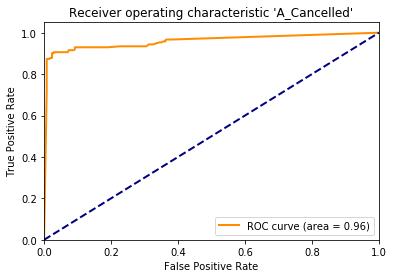

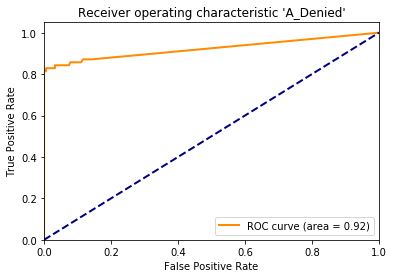

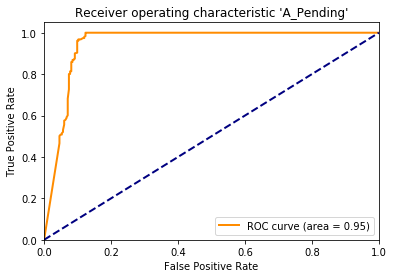

In [9]:
import sklearn.metrics as met
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
th=dict()
roc_auc = dict()
for i in range(3):
    fpr[i], tpr[i],th[i] = met.roc_curve(model.actual[model.actual.columns.values[i+1]],preds[preds.columns.values[i+1]])
    roc_auc[i] = auc(fpr[i], tpr[i])

for i in range(3):
    plt.figure()
    lw = i
    plt.plot(fpr[i], tpr[i], color='darkorange',
             lw=2, label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic %r' %model.actual.columns.values[i+1])
    plt.legend(loc="lower right")
    plt.show()

# Resalts

In [38]:
# KMeans start predicting the outcome correctely begining by n_events = 11 activities.

# KMeans doesn't able to predict the outcome when the request present the system fault from 'A_Submitted' to 'A_Accepted'.
# KMeans doesn't able to predict the outcome when the request present the system fault from 'A_Accepted' to O_Sent.
# KMeqns can predect outcome in an acceptable rate when the request present the system fault from'A_Validating' to desision.

# KMeans shows a good rate to estimate outcome by feading model in a system delay activities.

# More the activities in the trace, more prediction precies since the clustering depends on activities weights

# 81% avg correct prediction by three classes for test data AP=230 AD=230 AC=230 tot=960


# End,

In [39]:
model.actual[0:1]

Case ID  A_Cancelled  A_Denied  A_Pending
0  Application_821425679            0         0          1

In [40]:
preds[0:1]

Case ID  A_Cancelled  A_Denied  A_Pending
0  Application_1004303396          0.0       0.0        1.0

In [55]:
h='A_Denied'
uc=test_KMeans[test_KMeans['lbl']==h]['Case ID'].unique()
AD=test_KMeans[test_KMeans['Case ID'].isin(uc)][0:230]
h='A_Cancelled'
uc=test_KMeans[test_KMeans['lbl']==h]['Case ID'].unique()
AC=test_KMeans[test_KMeans['Case ID'].isin(uc)][0:230]
h='A_Pending'
uc=test_KMeans[test_KMeans['lbl']==h]['Case ID'].unique()
AP=test_KMeans[test_KMeans['Case ID'].isin(uc)][0:230]
AC=pd.concat([AC,AP],axis=0)
AC=pd.concat([AC,AD],axis=0)

In [57]:
test_KMeans=AC

In [59]:
test_cases_KMeans=test_KMeans['Case ID'].unique()

In [127]:
test_KMeans.shape

(690, 6)